In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
!pip install pydub
!apt-get install ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [14]:
import os
from pydub import AudioSegment
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder

In [15]:
def convert_mp3_to_wav(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    for root, _, files in os.walk(input_folder):
        for file in files:
            if file.endswith(".mp3"):
                mp3_path = os.path.join(root, file)
                wav_subfolder = os.path.join(output_folder, os.path.relpath(root, input_folder))
                if not os.path.exists(wav_subfolder):
                    os.makedirs(wav_subfolder)
                wav_path = os.path.join(wav_subfolder, os.path.splitext(file)[0] + ".wav")
                audio = AudioSegment.from_mp3(mp3_path)
                audio.export(wav_path, format="wav")
                print(f"Converted: {mp3_path} -> {wav_path}")


In [16]:
train_dir = "/content/drive/My Drive/stutter_datasets/train/"
train_wav_dir = "/content/drive/My Drive/stutter_datasets_wav/train/"
convert_mp3_to_wav(train_dir, train_wav_dir)

test_dir = "/content/drive/My Drive/stutter_datasets/test/"
test_wav_dir = "/content/drive/My Drive/stutter_datasets_wav/test/"
convert_mp3_to_wav(test_dir, test_wav_dir)

print("Train WAV files:", os.listdir(train_wav_dir))
print("Test WAV files:", os.listdir(test_wav_dir))

Converted: /content/drive/My Drive/stutter_datasets/train/Prolongations/ElevenLabs_2024-12-04T14_53_40_Roger_pre_s50_sb75_se0_b.mp3 -> /content/drive/My Drive/stutter_datasets_wav/train/Prolongations/ElevenLabs_2024-12-04T14_53_40_Roger_pre_s50_sb75_se0_b.wav
Converted: /content/drive/My Drive/stutter_datasets/train/Prolongations/ElevenLabs_2024-12-04T14_54_19_Alice_pre_s50_sb75_se0_b.mp3 -> /content/drive/My Drive/stutter_datasets_wav/train/Prolongations/ElevenLabs_2024-12-04T14_54_19_Alice_pre_s50_sb75_se0_b.wav
Converted: /content/drive/My Drive/stutter_datasets/train/Prolongations/ElevenLabs_2024-12-04T14_55_12_Bill_pre_s50_sb75_se0_b.mp3 -> /content/drive/My Drive/stutter_datasets_wav/train/Prolongations/ElevenLabs_2024-12-04T14_55_12_Bill_pre_s50_sb75_se0_b.wav
Converted: /content/drive/My Drive/stutter_datasets/train/Prolongations/ElevenLabs_2024-12-04T14_55_55_Callum_pre_s50_sb75_se0_b.mp3 -> /content/drive/My Drive/stutter_datasets_wav/train/Prolongations/ElevenLabs_2024-12-04

In [94]:
import librosa
import numpy as np
import os
import random
import soundfile as sf

def augment_audio_files(input_dir, output_dir, augmentations_per_sample=3):

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for class_label in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_label)
        output_class_path = os.path.join(output_dir, class_label)

        if not os.path.exists(output_class_path):
            os.makedirs(output_class_path)

        if os.path.isdir(class_path):
            for file in os.listdir(class_path):
                if file.endswith('.wav'):
                    file_path = os.path.join(class_path, file)

                    # Load audio
                    audio, sr = librosa.load(file_path, sr=None)

                    # Save original audio to the output directory
                    sf.write(os.path.join(output_class_path, file), audio, sr)

                    # Generate augmentations
                    for i in range(augmentations_per_sample):
                        augmented_audio = apply_random_augmentation(audio, sr)
                        augmented_file_name = f"aug_{i}_{file}"
                        sf.write(os.path.join(output_class_path, augmented_file_name), augmented_audio, sr)

def apply_random_augmentation(audio, sr):

    augmentation_functions = [
        lambda x: add_noise(x),
        lambda x: change_speed(x, factor=random.uniform(0.9, 1.1)),
        lambda x: change_pitch(x, sr, n_steps=random.randint(-2, 2)),
        lambda x: shift_audio(x)
    ]
    augmentation = random.choice(augmentation_functions)
    return augmentation(audio)

# Augmentation helper functions
def add_noise(audio, noise_level=0.005):

    noise = np.random.normal(0, noise_level, audio.shape)
    return audio + noise

def change_speed(audio, factor=1.0):

    return librosa.effects.time_stretch(audio, rate=factor)

def change_pitch(audio, sr, n_steps=0):

    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)

def shift_audio(audio, shift_max=0.2):

    shift = int(shift_max * len(audio) * random.choice([-1, 1]))
    return np.roll(audio, shift)

In [95]:
train_dir ="/content/drive/My Drive/stutter_datasets_wav/train/"
augmented_dir = "/content/drive/My Drive/stutter_datasets_wav/aug_train/"

augment_audio_files(train_dir, augmented_dir, augmentations_per_sample=3)

In [96]:
def extract_features(file_path, max_len=200):

    try:
        # Load the audio file
        audio, sample_rate = librosa.load(file_path, sr=None)

        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)

        # Pad or truncate to ensure consistent length
        if mfccs.shape[1] < max_len:
            mfccs = np.pad(mfccs, ((0, 0), (0, max_len - mfccs.shape[1])), mode='constant')
        else:
            mfccs = mfccs[:, :max_len]

        return mfccs
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [117]:
def load_data(data_dir, max_len=200):
    features = []
    labels = []
    for class_label in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_label)
        if not os.path.isdir(class_path):
            continue
        for file in os.listdir(class_path):
            if file.endswith('.wav'):
                file_path = os.path.join(class_path, file)
                mfccs = extract_features(file_path, max_len=max_len)
                if mfccs is not None:
                    features.append(mfccs)
                    labels.append([class_label])
    return np.array(features), np.array(labels)

In [118]:
train_dir = "/content/drive/My Drive/stutter_datasets_wav/aug_train/"
test_dir = "/content/drive/My Drive/stutter_datasets_wav/test/"

X_train, y_train = load_data(train_dir)
print("Unique labels in y_train:", set(label[0] for label in y_train))

X_test, y_test = load_data(test_dir)

Unique labels in y_train: {'Whole Word Repetitions', 'Prolongations', 'Single Syllable Repetitions'}


In [126]:
from sklearn.model_selection import train_test_split

X, y = load_data(train_dir)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Training labels distribution:", {label: list(y_train).count([label]) for label in set(label[0] for label in y_train)})
print("Test labels distribution:", {label: list(y_test).count([label]) for label in set(label[0] for label in y_test)})


Training labels distribution: {'Whole Word Repetitions': 64, 'Prolongations': 64, 'Single Syllable Repetitions': 64}
Test labels distribution: {'Whole Word Repetitions': 16, 'Prolongations': 16, 'Single Syllable Repetitions': 16}


In [128]:
from sklearn.preprocessing import MultiLabelBinarizer

class_labels = ['Single Syllable Repetitions', 'Whole Word Repetitions', 'Prolongations']
mlb = MultiLabelBinarizer(classes=class_labels)

y_train_multi = mlb.fit_transform(y_train)
y_test_multi = mlb.transform(y_test)

X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# Transform validation labels
y_train_split_multi = mlb.transform(y_train_split)
y_val_multi = mlb.transform(y_val)

print("Binary Labels Example (y_train_multi):", y_train_multi[:5])


Binary Labels Example (y_train_multi): [[0 1 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]]


In [129]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Bidirectional, Dense, Dropout, TimeDistributed, Reshape
from tensorflow.keras.layers import BatchNormalization

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),
    Reshape((-1, 64)),

    Bidirectional(LSTM(32)),
    Dropout(0.3),

    Dense(len(class_labels), activation='sigmoid')
])

from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 11, 198, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 11, 198, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 5, 99, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 5, 99, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 3, 97, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 3, 97, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 1, 48, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 1, 48, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_6 (Reshape)                  │ (None, 48, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,227 (172.76 KB)

 Trainable params: 44,035 (172.01 KB)

 Non-trainable params: 192 (768.00 B)

In [130]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [132]:
# Train model
history = model.fit(
    X_train_split, y_train_split_multi,
    validation_data=(X_val, y_val_multi),
    epochs=30,
    batch_size=16,
    callbacks=[early_stopping, reduce_lr],  # Added callbacks
    verbose=1
)

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 260ms/step - accuracy: 0.4323 - loss: 0.6703 - val_accuracy: 0.3333 - val_loss: 0.6205 - learning_rate: 0.0010
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.4765 - loss: 0.5802 - val_accuracy: 0.5641 - val_loss: 0.5977 - learning_rate: 0.0010
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.5159 - loss: 0.5602 - val_accuracy: 0.4615 - val_loss: 0.5986 - learning_rate: 0.0010
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.5782 - loss: 0.5497 - val_accuracy: 0.4872 - val_loss: 0.5796 - learning_rate: 0.0010
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.6052 - loss: 0.5138 - val_accuracy: 0.4872 - val_loss: 0.5641 - learning_rate: 0.0010
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.6748 - loss: 0.4825 - val_accuracy: 0.6154 - val_loss: 0.5276 - learning_rate: 0.0010
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.6553 - loss: 0.4831 - val_a

In [133]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_multi, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7604 - loss: 0.3730
Test Loss: 0.3823, Test Accuracy: 0.7500


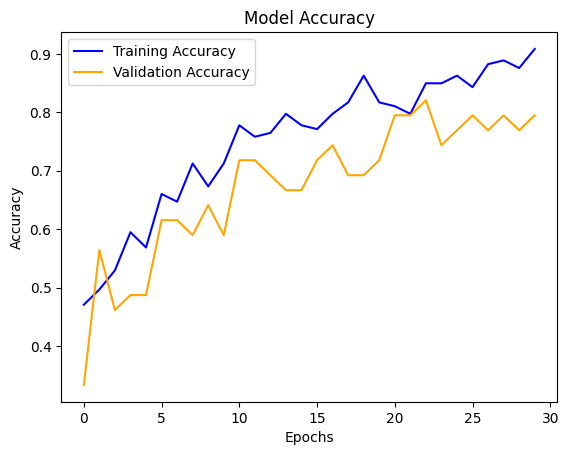

In [134]:
# Accuracy plot
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

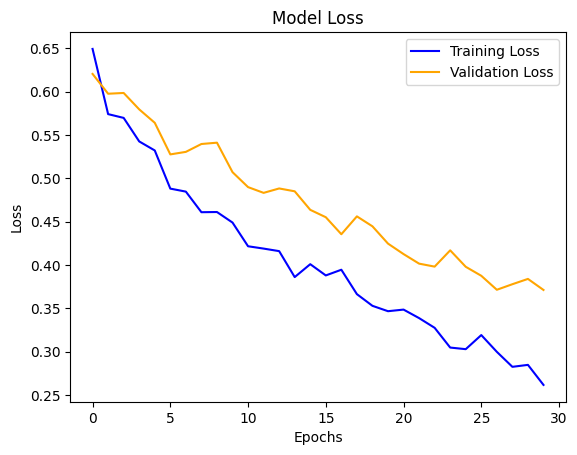

In [135]:
# Loss plot
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [142]:
# Classification report
print("Classification Report:\n", classification_report(true_labels_subset, (predictions > 0.5).astype(int), target_names=class_labels))

Classification Report:
                      precision    recall  f1-score   support

Syllable_repetition       0.00      0.00      0.00         1
    Word_repetition       0.00      0.00      0.00         0
      Prolongations       1.00      1.00      1.00         4

          micro avg       1.00      0.80      0.89         5
          macro avg       0.33      0.33      0.33         5
       weighted avg       0.80      0.80      0.80         5
        samples avg       0.80      0.80      0.80         5



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me

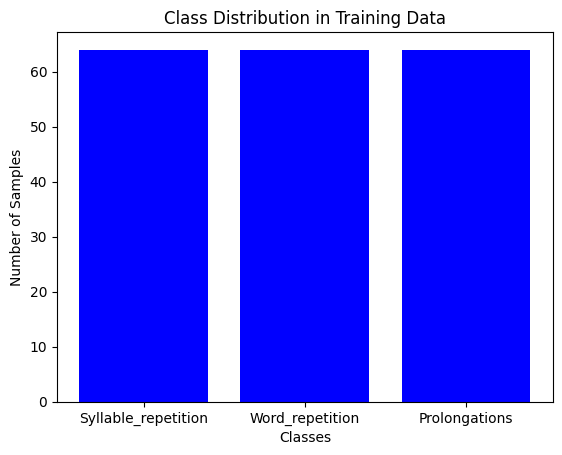

In [136]:
import matplotlib.pyplot as plt
import numpy as np

# Summing binary labels along the samples axis to get the count for each class
class_counts = np.sum(y_train_multi, axis=0)
class_labels = ['Syllable_repetition', 'Word_repetition', 'Prolongations']

# Bar plot for class distribution
plt.bar(class_labels, class_counts, color='blue')
plt.title('Class Distribution in Training Data')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.show()


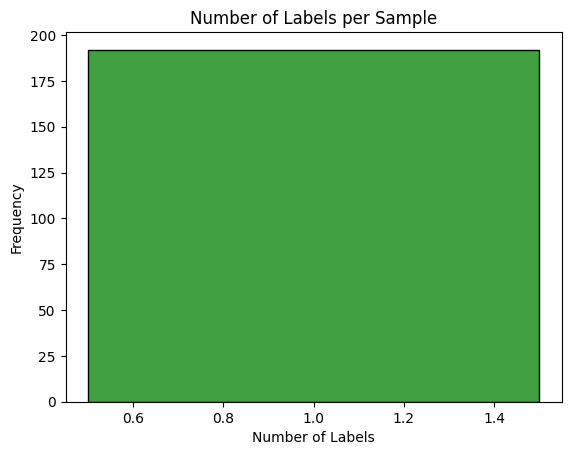

In [137]:
import seaborn as sns

# Count samples with multiple labels
num_labels_per_sample = np.sum(y_train_multi, axis=1)

# Histogram of number of labels per sample
sns.histplot(num_labels_per_sample, discrete=True, kde=False, color='green')
plt.title('Number of Labels per Sample')
plt.xlabel('Number of Labels')
plt.ylabel('Frequency')
plt.show()


In [138]:
# Predict on a few test samples
predictions = model.predict(X_test[:5])
predicted_classes = (predictions > 0.5).astype(int)  # Apply threshold

# Ensure y_test_multi is a NumPy array
y_test_multi = np.array(y_test_multi)

# Loop through predictions and true labels
for i in range(len(predictions)):
    print(f"Sample {i+1}")

    # Ensure both true and predicted labels are in the correct shape
    true_labels = mlb.inverse_transform(np.array([y_test_multi[i]]))[0]  # True labels
    predicted_labels = mlb.inverse_transform(np.array([predicted_classes[i]]))[0]  # Predicted labels

    # Print results
    print("True Labels:", true_labels)
    print("Predicted Labels:", predicted_labels)
    print()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
Sample 1
True Labels: ('Prolongations',)
Predicted Labels: ('Prolongations',)

Sample 2
True Labels: ('Prolongations',)
Predicted Labels: ('Prolongations',)

Sample 3
True Labels: ('Prolongations',)
Predicted Labels: ('Prolongations',)

Sample 4
True Labels: ('Single Syllable Repetitions',)
Predicted Labels: ()

Sample 5
True Labels: ('Prolongations',)
Predicted Labels: ('Prolongations',)



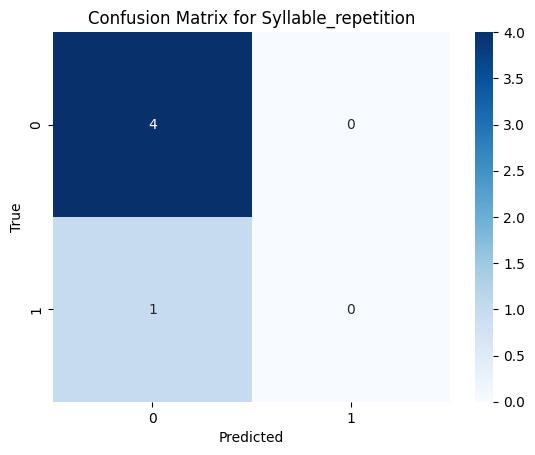

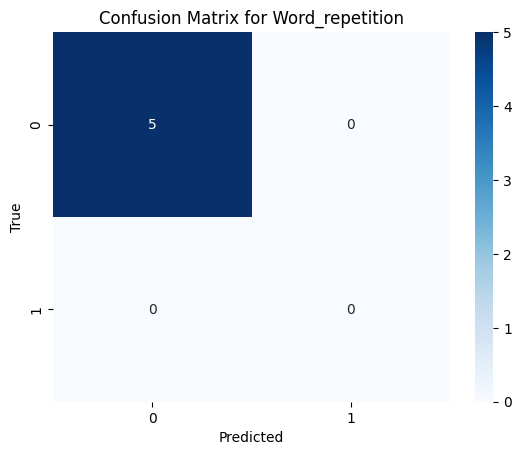

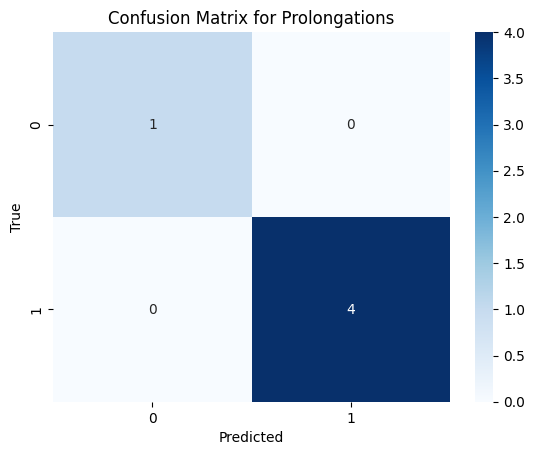

In [141]:
from sklearn.metrics import multilabel_confusion_matrix, classification_report

# Ensure consistent sample sizes
true_labels_subset = y_test_multi[:5]  # Use the first 5 labels to match predictions

# Generate confusion matrices for each class
confusion_matrices = multilabel_confusion_matrix(true_labels_subset, (predictions > 0.5).astype(int))

# Plot confusion matrix for each class
for i, label in enumerate(class_labels):
    cm = confusion_matrices[i]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {label}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


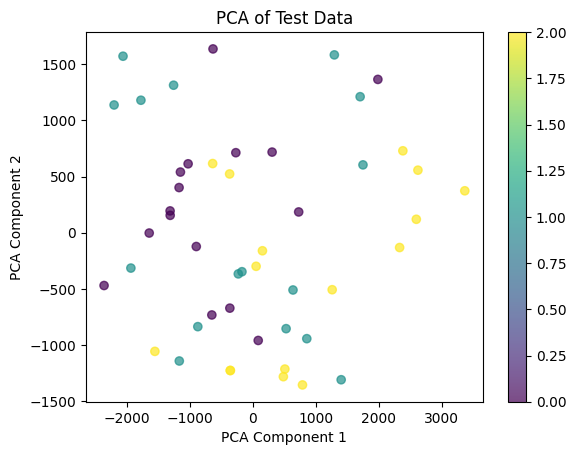

Number of samples in X_test_flat: 48


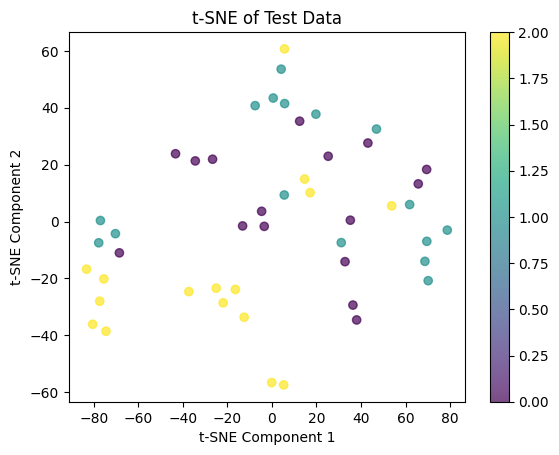

Shape of X_test_flat: (48, 2600)


In [140]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Flatten features to 2D for visualization
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_flat)

# Plot PCA results
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=np.argmax(y_test_multi, axis=1), cmap='viridis', alpha=0.7)
plt.title('PCA of Test Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()

# Check the number of samples in the test set
n_samples = X_test_flat.shape[0]
print(f"Number of samples in X_test_flat: {n_samples}")

# Set perplexity to a value less than the number of samples
tsne = TSNE(n_components=2, perplexity=min(5, n_samples - 1), random_state=42)  # Ensure perplexity < n_samples
X_tsne = tsne.fit_transform(X_test_flat)

# Plot t-SNE results
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=np.argmax(y_test_multi, axis=1), cmap='viridis', alpha=0.7)
plt.title('t-SNE of Test Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar()
plt.show()
print(f"Shape of X_test_flat: {X_test_flat.shape}")
